Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [16]:
import helper_fxns as hf
import transforms as tr
import importlib
import numpy as np
import os
import requests
import sys
import copy
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
with open("train_list.txt", "r") as f:
    vois = [x.split(',') for x in f.read().split("\n")]

voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})

voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [18]:
voi_df = pd.read_csv('vois.csv')

In [25]:
def extract_voi(img, vois, final_size = [24,24,12], aug=False):
    voi_imgs = []
    classes = []
    
    if aug:
        crop_size = [math.ceil(x*math.sqrt(2)) for x in final_size]
    else:
        crop_size = final_size
    
    for _, voi in vois.iterrows():
        xpad = crop_size[0] - (voi['x2']-voi['x1'])
        ypad = crop_size[1] - (voi['y2']-voi['y1'])
        zpad = crop_size[2] - (voi['z2']-voi['z1'])
        
        side_padding = math.ceil(max(xpad, ypad, zpad) / 2)
        #print(side_padding)
        
        pad_img = []
        
        for ch in range(img.shape[-1]):
            pad_img.append(np.pad(img[:,:,:,ch], side_padding, 'constant'))
            
        pad_img = np.stack(pad_img, axis=3)
        
        voi['x1'] += side_padding - math.ceil(xpad/2)
        voi['x2'] += side_padding + math.floor(xpad/2)
        voi['y1'] += side_padding - math.ceil(ypad/2)
        voi['y2'] += side_padding + math.floor(ypad/2)
        voi['z1'] += side_padding - math.ceil(zpad/2)
        voi['z2'] += side_padding + math.floor(zpad/2)
            
        if aug:
            base_img = pad_img[voi['x1']:voi['x2'], voi['y1']:voi['y2'], voi['z1']:voi['z2'], :]
            aug_imgs = augment(base_img, final_size)
            voi_imgs = voi_imgs + aug_imgs
            classes = classes + [voi['cls']] * len(aug_imgs)
            
        else:
            voi_imgs.append(pad_img[voi['x1']:voi['x2'], voi['y1']:voi['y2'], voi['z1']:voi['z2'], :])
            classes.append(voi['cls'])
    
    return voi_imgs, classes

In [26]:
def augment(img, final_size, num_samples = 40, translate=False):
    aug_imgs = []
    
    for _ in range(num_samples):
        #angle = random.randint(0, 359)
        #temp_img = tr.rotate(img, angle)
        
        #scale = [random.uniform(0.9, 1.1), random.uniform(0.9, 1.1), random.uniform(0.9, 1.1)]
        #temp_img = tr.scale3d(temp_img, scale)
        
        if translate:
            trans = [random.randint(-5, 5), random.uniform(-5, 5), random.uniform(-5, 5)]
        else:
            trans = [0,0,0]
        
        flip = [random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]
        
        crops = [temp_img.shape[i] - final_size[i] for i in range(3)]
        aug_imgs.append(temp_img[math.floor(crops[0]/2)*flip[0] + trans[0] : -math.ceil(crops[0]/2)*flip[0] + trans[0] : flip[0],
                                 math.floor(crops[1]/2)*flip[1] + trans[1] : -math.ceil(crops[1]/2)*flip[1] + trans[1] : flip[1],
                                 math.floor(crops[2]/2)*flip[2] + trans[2] : -math.ceil(crops[2]/2)*flip[2] + trans[2] : flip[2], :])
    
    return aug_imgs

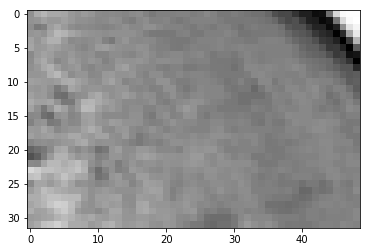

In [32]:
plt.imshow(cropped_imgs[0][:,:,5,0], cmap='gray')

In [37]:
for img_fn in os.listdir("full_imgs\\"):
    img = np.load("full_imgs\\"+img_fn)
    cropped_imgs, classes = extract_voi(img, voi_df[voi_df["Filename"] == img_fn], aug=False)
    
    for cl in set(classes):
        subdir = "train_imgs\\"+cl
        if not os.path.exists(subdir):
            os.makedirs(subdir)
            
    for i in range(len(classes)):
        np.save("train_imgs\\"+classes[i]+"\\"+img_fn[:-4]+"_"+str(i), cropped_imgs[i])

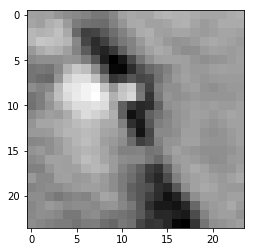

In [38]:
img = np.load("train_imgs\\hcc\\13010227_0.npy")
plt.imshow(img[:,:,5,0], cmap='gray')

In [8]:
def plot_section(img, df, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 1], (1,0)), cmap='gray')

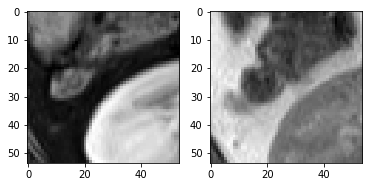

In [9]:
img_fn = "13010227.npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=20)

In [106]:
img[:,:,:,1].shape

(280, 214, 79)

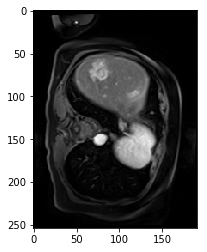

In [84]:
def aug_rotation(img, final_size, num_samples = 5):
    aug_imgs = []
    crops = [img.shape[i] - final_size[i] for i in range(3)]
    
    for _ in range(num_samples):
        angle = int(random.uniform(0, 360))
        aug_imgs.append(tr.rotate(img, angle)[math.floor(crops[0]/2):-math.ceil(crops[0]/2),
                                              math.floor(crops[1]/2):-math.ceil(crops[1]/2),
                                              math.floor(crops[2]/2):-math.ceil(crops[2]/2), :])
    
    return aug_imgs

In [52]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])